# part0: imports

In [25]:
import os, sys, pathlib
from pprint import pprint 
from importlib import reload
import logging
logging.basicConfig(level=logging.ERROR)



import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator


from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal

%matplotlib inline
reload(dt)

# Global params
root = pathlib.Path("/data")

BIN_SIZE = .03  # sec
WINDOW_prep = (-.39, .06)  # sec
WINDOW_exec = (-.12, .42)  # sec
n_components = 10  # min between M1 and PMd

In [4]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

In [5]:
%run dataset_selection.ipynb

the variable `GoodDataList` contains the session names


## Control

let's find a lower-bound. Canonical correlation without matching the animal, the area, the epoch and the target!

### Details
- **animal**: $C_L$  is Chewie
- **window**: For *M1* it is $-120ms \sim +420ms$ and for *PMd* from $-390ms  \sim +60ms$
- **dim**: it is 10 for M1 and 15 for PMd
- **preprocessing**: 
    - remove firing rate below 1Hz overall
    - bin to 30ms
    - square root transform
    - smooth by Gaussian kernel, $\sigma=50ms$
    
I'm including only one session per animal

In [6]:
areas = ('M1', 'PMd')

pairFileList = []
for animal1 in GoodDataList[areas[0]]:
    for animal2 in GoodDataList[areas[1]]:
        if animal2  == animal1 or '2' in animal1 or '2' in animal2:  # to removre Chewie2
            continue
        path1 = root/animal1/GoodDataList[areas[0]][animal1][0]
        path2 = root/animal2/GoodDataList[areas[1]][animal2][0]
        pairFileList.append((pyal.mat2dataframe(path1, shift_idx_fields=True),
                             pyal.mat2dataframe(path2, shift_idx_fields=True)))
        
print(f'{len(pairFileList)=}')

len(pairFileList)=7


In [14]:
def prep_general (df, area='M1'):
    "preprocessing general!"
    
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_ = pyal.remove_low_firing_neurons(df, f"{area}_spikes", 1)
    
    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    assert np.all(df_.bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    
    df_ = pyal.sqrt_transform_signal(df_, f"{area}_spikes")
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    
    return df_


pairFileList_ready = [(prep_general(df1),prep_general(df2)) for  df1,df2 in pairFileList]

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )

/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and divi

collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

In [24]:
side1df = [df for df,_ in pairFileList_ready]
side2df = [df for _,df in pairFileList_ready]

AllData1 = dt.get_data_array(side1df, exec_epoch, area='M1', n_components=n_components)
AllData2 = dt.get_data_array(side2df, prep_epoch, area='PMd', n_components=n_components)

_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

do the CCA calculation

In [32]:
CCs=[]
for session, (sessionData1,sessionData2) in enumerate(zip(AllData1,AllData2)):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_components))
    CCs.append(np.mean(dt.canoncorr(data1, data2)[:4]))
CCs = np.array(CCs).T

(0.0, 1.0)

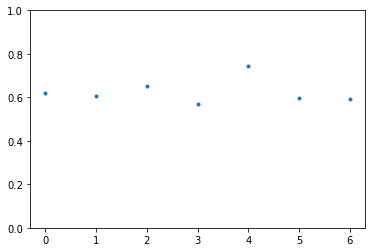

In [33]:
plt.plot(CCs.T,'.')
plt.ylim([0,1])

the average distribution of CCs

In [38]:
CCs=[]
for session, (sessionData1,sessionData2) in enumerate(zip(AllData1,AllData2)):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_components))
    CCs.append(dt.canoncorr(data1, data2))
CCs = np.array(CCs).T

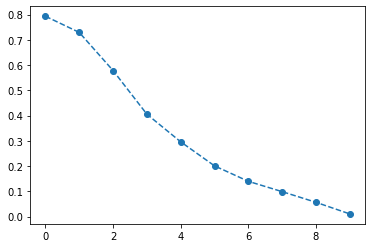

In [40]:
plt.plot(np.mean(CCs,axis=1), '--o')